## 1. 环境准备

In [1]:
from mmdet.apis import init_detector, inference_detector
from mmdet.registry import VISUALIZERS
import mmcv
import os
import matplotlib.pyplot as plt

/root/miniconda3/envs/openmmlab/lib/python3.8/site-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \


## 2. 配置文件、权重路径 与 模型初始化

In [2]:
# 配置和权重
config_file     = 'configs/voc_mask_rcnn_r50_fpn.py'
pretrained_ckpt = 'checkpoints/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth'
finetuned_ckpt  = 'work_dirs/voc_mask_rcnn_r50_fpn/epoch_12.pth'
device = 'cuda:0'

# 初始化“训练前/训练后”模型
model_pre  = init_detector(config_file, pretrained_ckpt, device=device)
model_post = init_detector(config_file, finetuned_ckpt,  device=device)

# 结果保存（可选）
out_dir = 'demo/results'
os.makedirs(out_dir, exist_ok=True)

Loads checkpoint by local backend from path: checkpoints/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth
The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([21, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([21]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([80, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([80]).
size mismatch for roi_head.mask_head.conv_logits.weight: copying a param with shape torch.Size([80, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([20, 

/root/miniconda3/envs/openmmlab/lib/python3.8/site-packages/mmengine/runner/checkpoint.py:347: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename

Loads checkpoint by local backend from path: work_dirs/voc_mask_rcnn_r50_fpn/epoch_12.pth


## 3. 批量推理并缓存可视化图像

### 数据集内图片对比

In [3]:
img_paths = [
    'demo/000001.jpg',
    'demo/000002.jpg',
    'demo/000003.jpg',
    'demo/000004.jpg'
]

imgs_pre_vis, imgs_post_vis = [], []

for img_path in img_paths:
    img = mmcv.imread(img_path)
    res_pre  = inference_detector(model_pre,  img)
    res_post = inference_detector(model_post, img)

    # 前模型可视化
    viz_pre = VISUALIZERS.build(model_pre.cfg.visualizer)
    viz_pre.dataset_meta = model_pre.dataset_meta
    viz_pre.add_datasample(
        'pre', image=img, data_sample=res_pre,
        draw_gt=False, pred_score_thr=0.15, show=False
    )
    imgs_pre_vis.append(viz_pre.get_image())

    # 后模型可视化
    viz_post = VISUALIZERS.build(model_post.cfg.visualizer)
    viz_post.dataset_meta = model_post.dataset_meta
    viz_post.add_datasample(
        'post', image=img, data_sample=res_post,
        draw_gt=False, pred_score_thr=0.5, show=False
    )
    imgs_post_vis.append(viz_post.get_image())

/root/miniconda3/envs/openmmlab/lib/python3.8/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '
/root/miniconda3/envs/openmmlab/lib/python3.8/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmdet.visualization.local_visualizer.DetLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(
/root/miniconda3/envs/openmmlab/lib/python3.8/site-packages/mmengine/visualization/visualizer.py:760: UserWarning: Warning: The bbox is out of bounds, the drawn bbox may not be in the image
  warnings.warn(
/root/miniconda3/envs/openmmlab/lib/python3.8/site-packages/mmengine/visualization/visualizer.py:831: UserWarning: Warning: The polygon is out of bounds, the drawn polygon may not be in the image
  warning

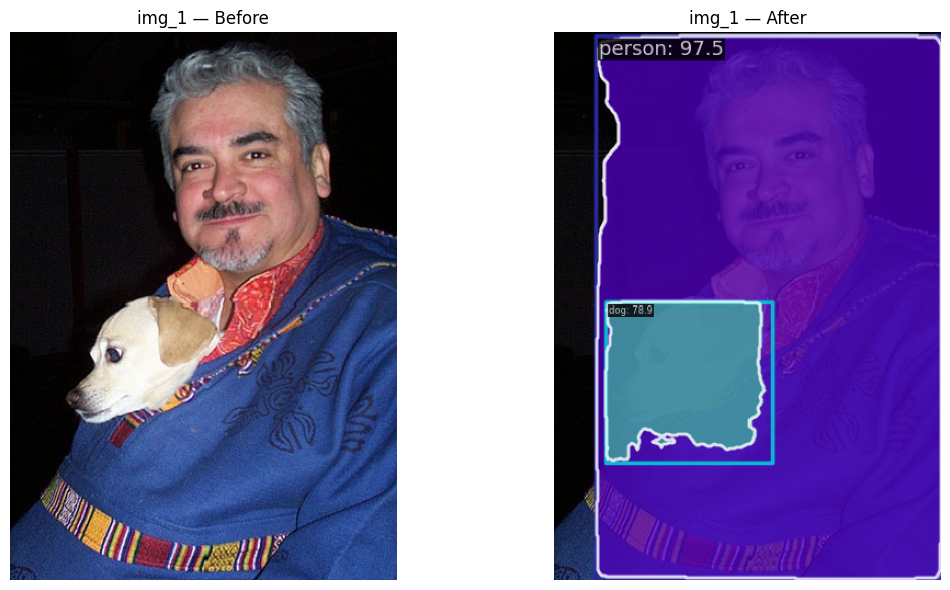

对比图已保存到：demo/results/Mask_RCNN/img_1_comparison_in.png


In [4]:
# 展示第 1 张图的对比
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(mmcv.bgr2rgb(imgs_pre_vis[0]))
axes[0].set_title('img_1 — Before')
axes[0].axis('off')

axes[1].imshow(mmcv.bgr2rgb(imgs_post_vis[0]))
axes[1].set_title('img_1 — After')
axes[1].axis('off')

plt.tight_layout()

# 保存对比图
output_path = 'demo/results/Mask_RCNN/img_1_comparison_in.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 可以根据需求调整
plt.show()

print(f'对比图已保存到：{output_path}')

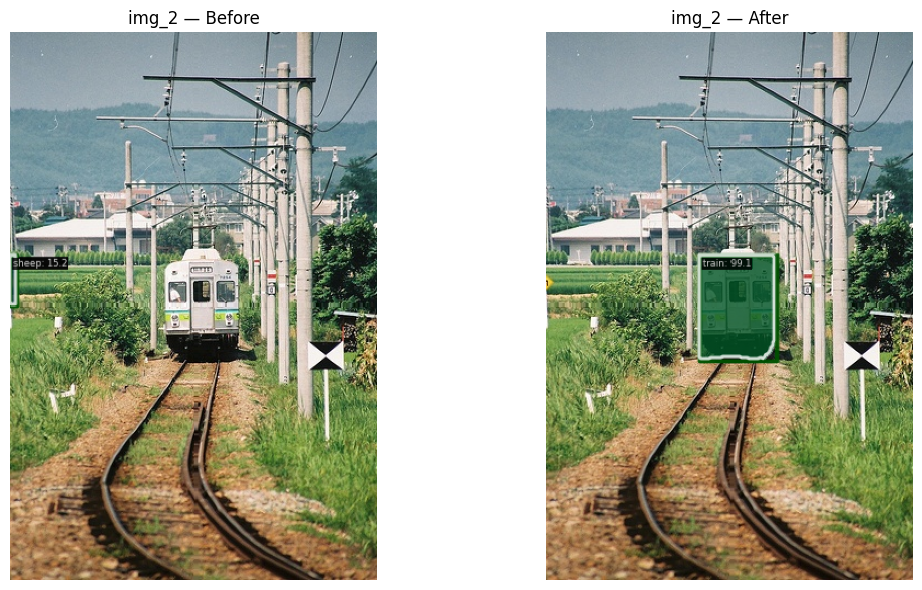

对比图已保存到：demo/results/Mask_RCNN/img_2_comparison_in.png


In [5]:
# 展示第 2 张图的对比
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(mmcv.bgr2rgb(imgs_pre_vis[1]))
axes[0].set_title('img_2 — Before')
axes[0].axis('off')

axes[1].imshow(mmcv.bgr2rgb(imgs_post_vis[1]))
axes[1].set_title('img_2 — After')
axes[1].axis('off')

plt.tight_layout()

# 保存对比图
output_path = 'demo/results/Mask_RCNN/img_2_comparison_in.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 可以根据需求调整
plt.show()

print(f'对比图已保存到：{output_path}')

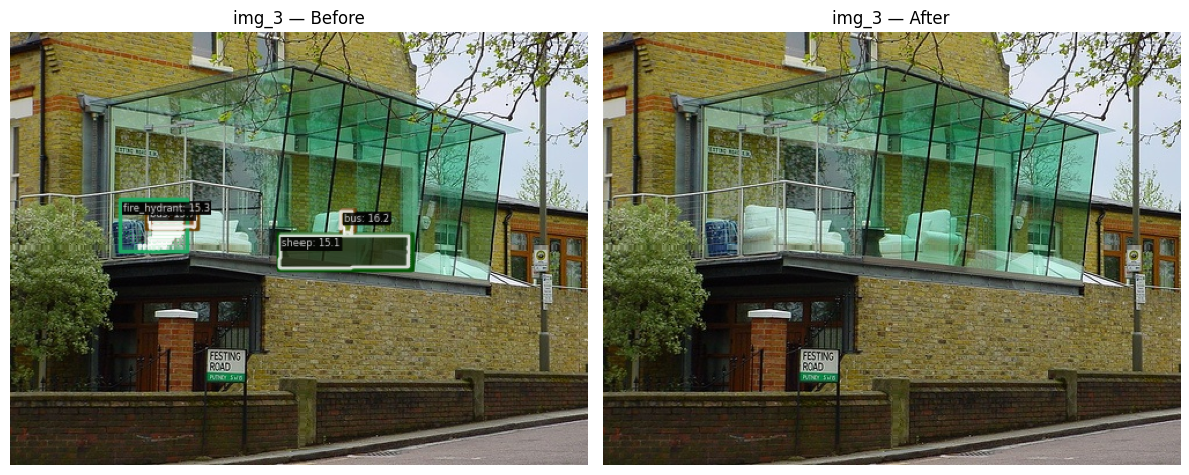

对比图已保存到：demo/results/Mask_RCNN/img_3_comparison_in.png


In [6]:
# 展示第 3 张图的对比
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(mmcv.bgr2rgb(imgs_pre_vis[2]))
axes[0].set_title('img_3 — Before')
axes[0].axis('off')

axes[1].imshow(mmcv.bgr2rgb(imgs_post_vis[2]))
axes[1].set_title('img_3 — After')
axes[1].axis('off')

plt.tight_layout()

# 保存对比图
output_path = 'demo/results/Mask_RCNN/img_3_comparison_in.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 可以根据需求调整
plt.show()

print(f'对比图已保存到：{output_path}')

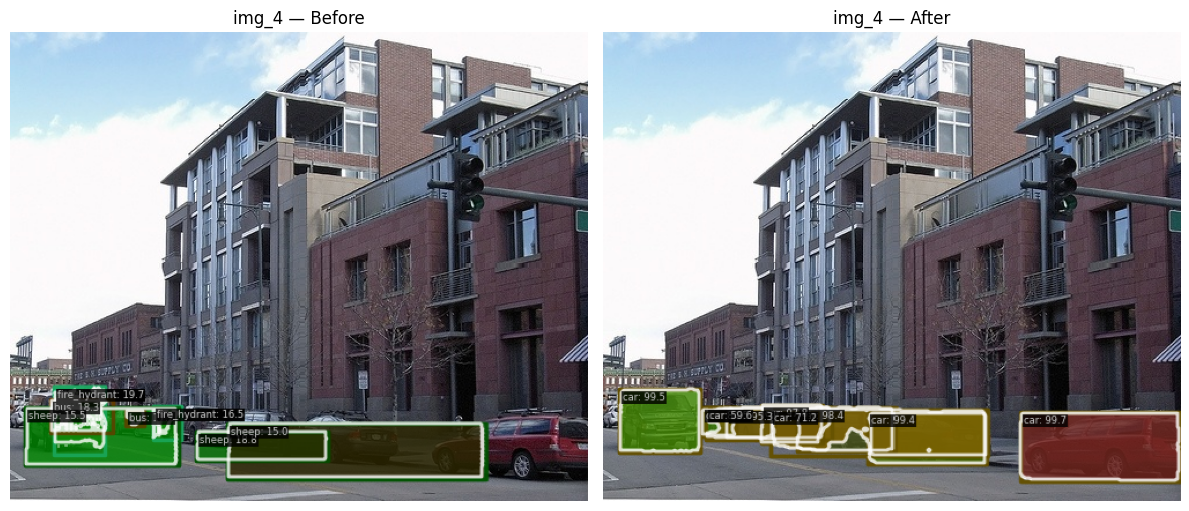

对比图已保存到：demo/results/Mask_RCNN/img_4_comparison_in.png


In [7]:
# 展示第 4 张图的对比
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(mmcv.bgr2rgb(imgs_pre_vis[3]))
axes[0].set_title('img_4 — Before')
axes[0].axis('off')

axes[1].imshow(mmcv.bgr2rgb(imgs_post_vis[3]))
axes[1].set_title('img_4 — After')
axes[1].axis('off')

plt.tight_layout()

# 保存对比图
output_path = 'demo/results/Mask_RCNN/img_4_comparison_in.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 可以根据需求调整
plt.show()

print(f'对比图已保存到：{output_path}')

### 数据集外图片对比

In [8]:
# 四张图片路径
image_paths = [
    'demo/img_1.jpg',
    'demo/img_2.jpg',
    'demo/img_3.jpg',
    'demo/img_4.jpg',
]

# 存放可视化结果的列表
imgs_pre_vis  = []
imgs_post_vis = []

for img_path in image_paths:
    img = mmcv.imread(img_path)
    # 推理
    res_pre  = inference_detector(model_pre,  img)
    res_post = inference_detector(model_post, img)

    # 前模型可视化
    viz_pre = VISUALIZERS.build(model_pre.cfg.visualizer)
    viz_pre.dataset_meta = model_pre.dataset_meta
    viz_pre.add_datasample('pre', image=img, data_sample=res_pre,
                          draw_gt=False, pred_score_thr=0.15, show=False)
    imgs_pre_vis.append(viz_pre.get_image())

    # 后模型可视化
    viz_post = VISUALIZERS.build(model_post.cfg.visualizer)
    viz_post.dataset_meta = model_post.dataset_meta
    viz_post.add_datasample('post', image=img, data_sample=res_post,
                           draw_gt=False, pred_score_thr=0.5, show=False)
    imgs_post_vis.append(viz_post.get_image())

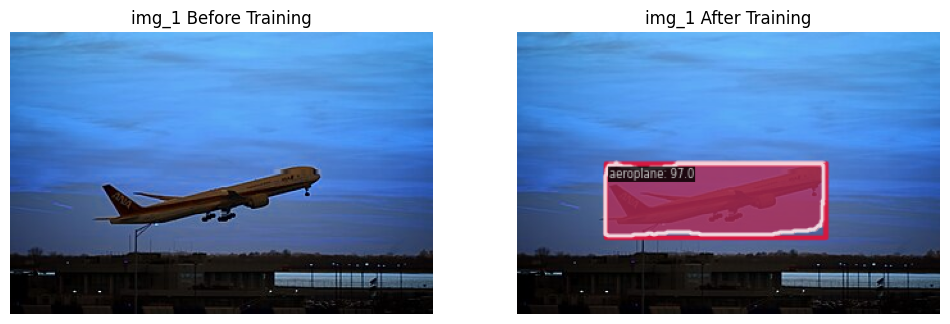

对比图已保存到：demo/results/Mask_RCNN/img_1_comparison_out.png


In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(imgs_pre_vis[0])
ax[0].set_title('img_1 Before Training')
ax[0].axis('off')

ax[1].imshow(imgs_post_vis[0])
ax[1].set_title('img_1 After Training')
ax[1].axis('off')

# 保存对比图
output_path = 'demo/results/Mask_RCNN/img_1_comparison_out.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 可以根据需求调整
plt.show()

print(f'对比图已保存到：{output_path}')

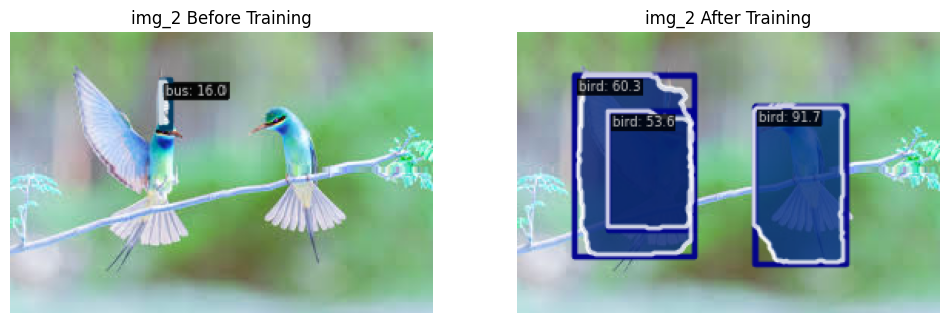

对比图已保存到：demo/results/Mask_RCNN/img_2_comparison_out.png


In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(imgs_pre_vis[1])
ax[0].set_title('img_2 Before Training')
ax[0].axis('off')

ax[1].imshow(imgs_post_vis[1])
ax[1].set_title('img_2 After Training')
ax[1].axis('off')

# 保存对比图
output_path = 'demo/results/Mask_RCNN/img_2_comparison_out.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 可以根据需求调整
plt.show()

print(f'对比图已保存到：{output_path}')

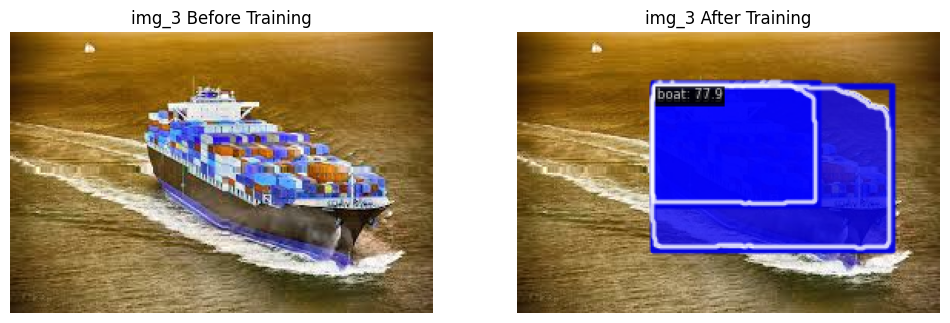

对比图已保存到：demo/results/Mask_RCNN/img_3_comparison_out.png


In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(imgs_pre_vis[2])
ax[0].set_title('img_3 Before Training')
ax[0].axis('off')

ax[1].imshow(imgs_post_vis[2])
ax[1].set_title('img_3 After Training')
ax[1].axis('off')

# 保存对比图
output_path = 'demo/results/Mask_RCNN/img_3_comparison_out.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 可以根据需求调整
plt.show()

print(f'对比图已保存到：{output_path}')

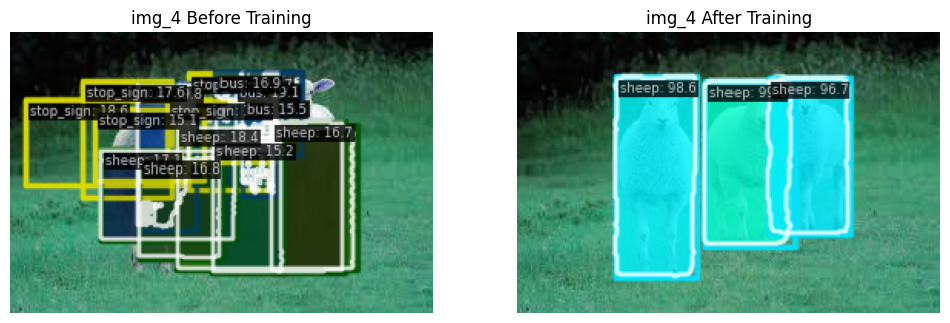

对比图已保存到：demo/results/Mask_RCNN/img_4_comparison_out.png


In [12]:
# %%
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(imgs_pre_vis[3])
ax[0].set_title('img_4 Before Training')
ax[0].axis('off')

ax[1].imshow(imgs_post_vis[3])
ax[1].set_title('img_4 After Training')
ax[1].axis('off')

# 保存对比图
output_path = 'demo/results/Mask_RCNN/img_4_comparison_out.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 可以根据需求调整
plt.show()

print(f'对比图已保存到：{output_path}')